# Deep-learning-project, Jovian

Classification of Rice types from Kaggle Rice Image Dataset 

### TO DO 
----------------------
1.  Select a dataset
2.  Downloading the dataset
3.  Importing the dataset using PyTorch
4.  Exploring the dataset
5.  Prepare the dataset for training 
6.  Create a Neural Network Model
7.  Train the model
8.  Plot Accuracies and Loss
9.  Test the model with the random sample from the dataset

In [1]:
# Installing the Jovian python library and the opendatasets library 
!pip install opendatasets --upgrade --quiet
# !pip install jovian --quiet

In [2]:
# Importing all the necessary libraries
# import jovian
import opendatasets as od
import torchvision
import os
import torch
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Selected the Rice Image dataset to classify the images based on the type of rice
dataset_url = 'https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset'

In [4]:
# Dowloading the dataset from kaggle using the open datasets library
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  ashutoshdinesh


Your Kaggle Key:

  ································


100%|██████████| 219M/219M [00:01<00:00, 186MB/s] 


In [5]:
# Setting the path to the directory where the images are located
data_dir = './rice-image-dataset/Rice_Image_Dataset'

In [6]:
# Displaying all the subfolders of the Image Directory
os.listdir(data_dir)

['Karacadag',
 'Ipsala',
 'Basmati',
 'Arborio',
 'Rice_Citation_Request.txt',
 'Jasmine']

In [7]:
# Removing the extra file in the directory for processing the data
os.remove(data_dir+'/Rice_Citation_Request.txt')

In [8]:
# Displaying the total number of images under each Rice type 

for cls in os.listdir(data_dir):
  print(cls, ':', len(os.listdir(data_dir + '/' + cls)))

Karacadag : 15000
Ipsala : 15000
Basmati : 15000
Arborio : 15000
Jasmine : 15000


### Importing Dataset into Pytorch

I am using the `ImageFolder` class from `torchvision`


The `ImageFolder` Class creates a datasets of images and labels by converting the folder names of the images to the labels of the images 

Documentation link : https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html

In [9]:
# Creating the dataset using Imageloader
dataset = ImageFolder(data_dir)

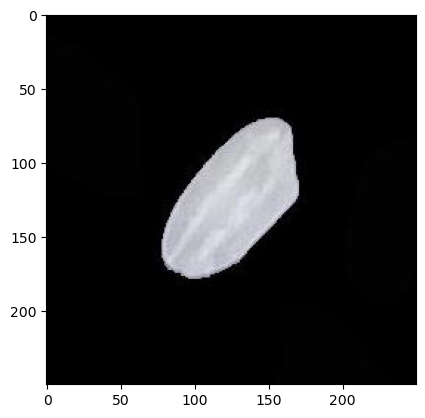

In [10]:
# Trying to load a random sample from the dataset and viewing it
img, label = dataset[12345]
plt.imshow(img)

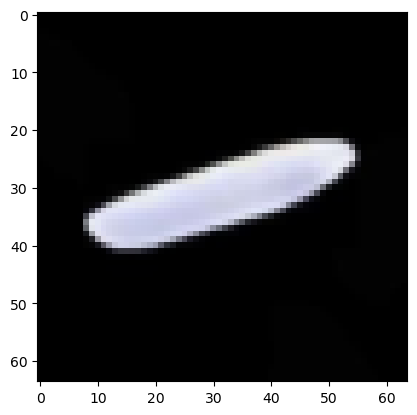

In [11]:
# Transforming data to a tensor, reducing its size and cropping it
dataset = ImageFolder(data_dir, tt.Compose([tt.Resize(64), 
                                            tt.RandomCrop(64),
                                                          tt.ToTensor()]))

img, label = dataset[23456]
plt.imshow(img.permute((1, 2, 0)))

In [12]:
# Splitting the Dataset into Train, validation and Test Datasets

val_pct = 0.2                                       # Percentage of dataset to be selected as Validation Data
test_pct = 0.1                                      # Percentage of dataset to be selected as Test Data

# Calculating the size of the Train, Test and Validation datasets
val_size = int(val_pct * len(dataset))              
test_size = int(test_pct * len(dataset))
train_size = len(dataset) - val_size - test_size

# Splitting the dataset randomly usin the random_plit function from the torch.utils.data library 
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

print(len(train_ds), len(val_ds), len(test_ds))

52500 15000 7500


In [13]:
# Splitting the Data into batches for training 

batch_size = 128        

train_dl = DataLoader(train_ds, 
                          batch_size, 
                          shuffle=True, 
                          num_workers=4, 
                          pin_memory=True)

val_dl = DataLoader(val_ds, 
                        batch_size, 
                        num_workers=4, 
                        pin_memory=True)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


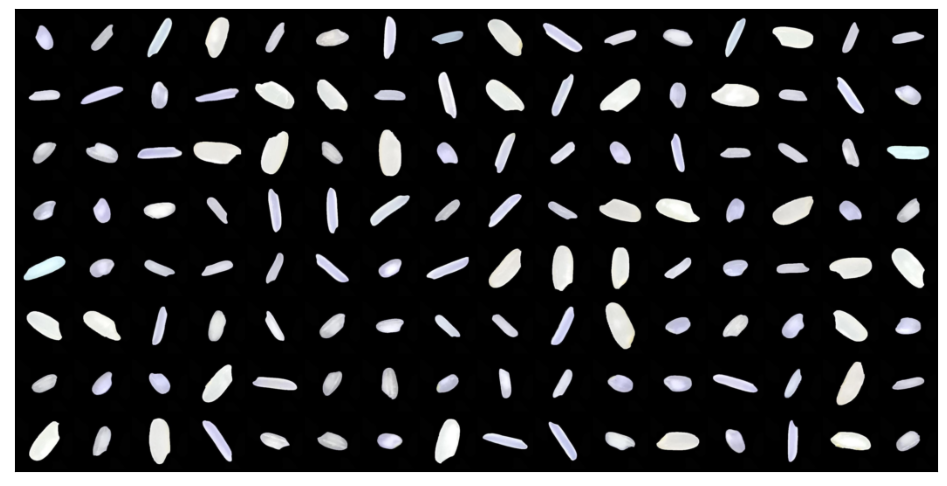

In [14]:
# Visualising the images in one batch as a grid of images

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        plt.show()
        break


show_batch(train_dl)

In [15]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [16]:
# Creating the Neural Network Model's Base Class

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)  # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()  # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [17]:
# Function to Calculate the accuracy of the model
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [18]:
@torch.no_grad()
def evaluate(model, val_loader):  # This Function evaluates the models performance and outputs the loss and accuracy
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

# Main Function of training the model
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history



### Model

In [19]:
#  Creating a CNN architecture and inheriting from the base class ImageClassificationBase

class RICECnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Input : 64 x 3 x 128 x 128
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), # Output : 128 x 32 x 64 x 64
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # Output : 128 x 64 x 64 x 64
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # output: 128 x 64 x 32 x 32

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), # Output : 128 x 128 x 32 x 32
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1), # Output : 128 x 128 x 32 x 32
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output : 128 x 128 x 16 x 16

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1), # Output : 128 x 256 x 16 x 16
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1), # Output : 128 x 256 x 16 x 16
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output : 128 x 256 x 8 x 8

            nn.Flatten(),
            nn.Linear(256 * 8 * 8, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 5))

    def forward(self, xb):
        return self.network(xb)

In [20]:
# Converting all Tensors and model to run on the specified device, in this case is CUDA
device = get_default_device()
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
model = to_device(RICECnnModel(), device)

Passing one batch of input tensors to check if there are no errors in the architecture of the neural network 

In [21]:
for batch in train_dl:
  images, labels = batch
  print('Shape',images.shape)
  print(images.device)
  preds = model(images)
  print('Preds.Shape',preds.shape)
  break

Shape torch.Size([128, 3, 64, 64])
cuda:0
Preds.Shape torch.Size([128, 5])


### Training Phase


In [22]:
model = to_device(RICECnnModel(), device)

# Calculating the baseline of the model without training 
history = [evaluate(model, val_dl)]
history

[{'val_loss': 1.6098097562789917, 'val_acc': 0.20085187256336212}]

In [23]:
#  Setting the hyperparameters before training
num_epochs = 5
opt_func = torch.optim.Adam  # Using ADAM optimizer 
lr = 0.001 # Learning Rate

# Training and displaying accuracy and loss
history += fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.2973, val_loss: 0.1055, val_acc: 0.9616
Epoch [1], train_loss: 0.0936, val_loss: 0.1234, val_acc: 0.9582
Epoch [2], train_loss: 0.0651, val_loss: 0.0653, val_acc: 0.9778
Epoch [3], train_loss: 0.0562, val_loss: 0.0563, val_acc: 0.9829
Epoch [4], train_loss: 0.0414, val_loss: 0.0324, val_acc: 0.9898


### Plotting the accuracy and loss

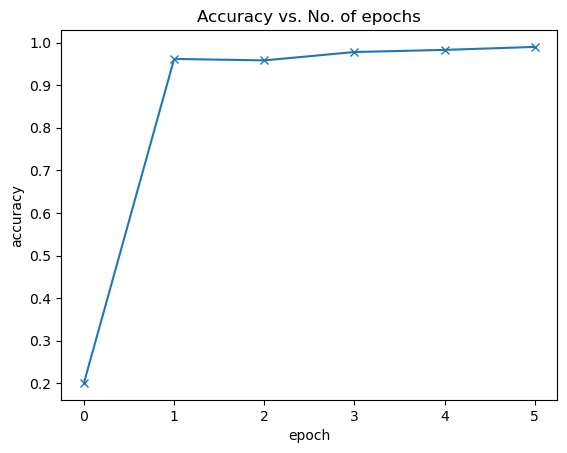

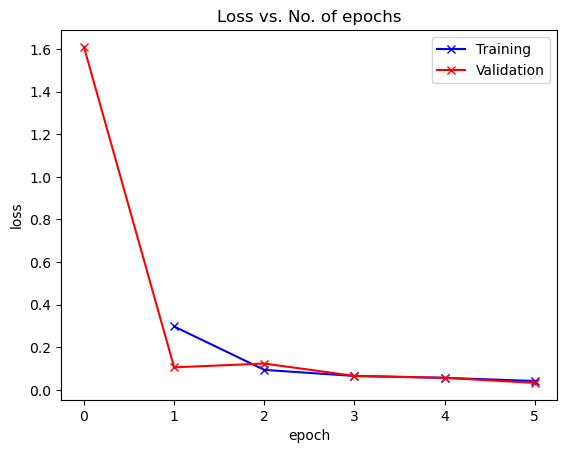

In [26]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.show()

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()


plot_accuracies(history)
plot_losses(history)

### Prediction for the test dataset

In [27]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: Basmati , Predicted: Basmati
{'val_loss': 0.037415292114019394, 'val_acc': 0.98828125}


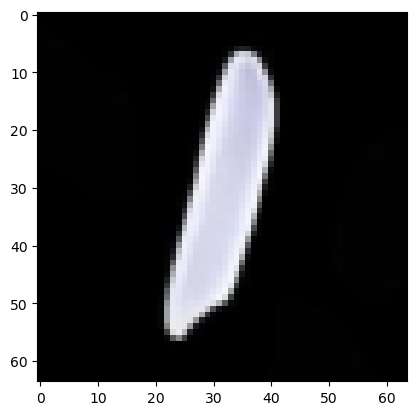

In [29]:
img, label = test_ds[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

test_loader = DeviceDataLoader(DataLoader(test_ds, batch_size*2), device)
result = evaluate(model, test_loader)
print(result)

### Saving the model

In [34]:
torch.save(model.state_dict(), './Rice-cnn.pth')

### Recording the results

In [37]:
!pip install jovian --quiet

import jovian
jovian.reset()
jovian.log_dataset(image_size=64)
jovian.log_hyperparams(batch_size=128, 
                       epochs=5, 
                       arch='CNN', 
                       lrs=[0.001],
                       opt=['Adam'])
jovian.log_metrics(train_loss = history[-1]['train_loss'],
                   val_acc = history[-1]['val_acc'],
                   val_loss = history[-1]['val_loss']
                   )

<IPython.core.display.Javascript object>

[jovian] Please enter your API key ( from https://jovian.com/ ):
API KEY:

  ···································································································································································································································································································································


[jovian] Dataset logged.
[jovian] Hyperparams logged.
[jovian] Metrics logged.
